## Multivariate LSTM Forecast model for multiple outputs

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var32(t-1)  var33(t-1)  \
1        0.0        0.0        0.0         0.0  ...         0.0         0.0   
2        0.0        0.0        0.0         0.0  ...         0.0         0.0   
3        0.0        0.0        0.0         0.0  ...         0.0         0.0   
4        0.0        0.0        0.0         0.0  ...         0.0         0.0   
5        0.0        0.0        1.0         1.0  ...         0.0         0.0   

   var34(t-1)  var35(t-1)  var36(t-1)  var37(t-1)  var38(t-1)  var39(t-1)  \
1         0.0        

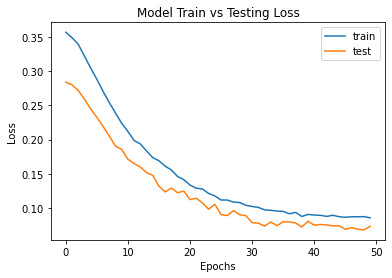

Test RMSE: 172.002
Test MAE: 146.048


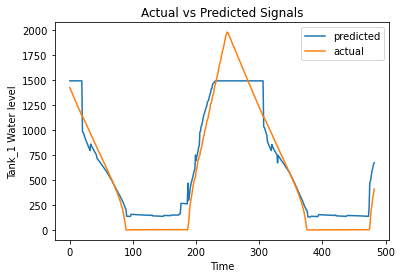

In [20]:
from math import sqrt
from numpy import array
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# load dataset
dataset = read_csv('phy_att_test_processed.csv', header=0, index_col=0)
values = dataset.to_numpy()
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]], axis=1, inplace=True)
reframed.drop(reframed.columns[[41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
#n_train_hours = 484
n_train_hours = 1936
# Not 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(5, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mae', optimizer='adam')
# fit network
#history = model.fit(train_X, train_y, epochs=70, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

'''
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(test_y, label='actual')
pyplot.legend()
pyplot.show()
'''

# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

# # Save the model to disk
# model.save('lstm_model.h5')
# print('Model saved to disk')

pyplot.xlabel('Time')
pyplot.ylabel('Tank_1 Water level')
pyplot.title('Actual vs Predicted Signals')
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
# pyplot.legend(['train','test'], loc='upper left')
pyplot.show()


Epoch 1/200
24/24 - 5s - loss: 0.2239 - val_loss: 0.2283 - 5s/epoch - 195ms/step
Epoch 2/200
24/24 - 0s - loss: 0.2063 - val_loss: 0.2120 - 154ms/epoch - 6ms/step
Epoch 3/200
24/24 - 0s - loss: 0.1844 - val_loss: 0.1924 - 140ms/epoch - 6ms/step
Epoch 4/200
24/24 - 0s - loss: 0.1474 - val_loss: 0.1663 - 150ms/epoch - 6ms/step
Epoch 5/200
24/24 - 0s - loss: 0.0963 - val_loss: 0.1558 - 150ms/epoch - 6ms/step
Epoch 6/200
24/24 - 0s - loss: 0.0822 - val_loss: 0.1505 - 140ms/epoch - 6ms/step
Epoch 7/200
24/24 - 0s - loss: 0.0786 - val_loss: 0.1479 - 150ms/epoch - 6ms/step
Epoch 8/200
24/24 - 0s - loss: 0.0748 - val_loss: 0.1456 - 150ms/epoch - 6ms/step
Epoch 9/200
24/24 - 0s - loss: 0.0723 - val_loss: 0.1439 - 150ms/epoch - 6ms/step
Epoch 10/200
24/24 - 0s - loss: 0.0708 - val_loss: 0.1426 - 160ms/epoch - 7ms/step
Epoch 11/200
24/24 - 0s - loss: 0.0692 - val_loss: 0.1408 - 160ms/epoch - 7ms/step
Epoch 12/200
24/24 - 0s - loss: 0.0674 - val_loss: 0.1403 - 150ms/epoch - 6ms/step
Epoch 13/200
2

Epoch 100/200
24/24 - 0s - loss: 0.0148 - val_loss: 0.0233 - 153ms/epoch - 6ms/step
Epoch 101/200
24/24 - 0s - loss: 0.0151 - val_loss: 0.0226 - 148ms/epoch - 6ms/step
Epoch 102/200
24/24 - 0s - loss: 0.0150 - val_loss: 0.0216 - 134ms/epoch - 6ms/step
Epoch 103/200
24/24 - 0s - loss: 0.0156 - val_loss: 0.0226 - 151ms/epoch - 6ms/step
Epoch 104/200
24/24 - 0s - loss: 0.0149 - val_loss: 0.0207 - 148ms/epoch - 6ms/step
Epoch 105/200
24/24 - 0s - loss: 0.0141 - val_loss: 0.0217 - 150ms/epoch - 6ms/step
Epoch 106/200
24/24 - 0s - loss: 0.0158 - val_loss: 0.0207 - 197ms/epoch - 8ms/step
Epoch 107/200
24/24 - 0s - loss: 0.0150 - val_loss: 0.0204 - 139ms/epoch - 6ms/step
Epoch 108/200
24/24 - 0s - loss: 0.0150 - val_loss: 0.0206 - 166ms/epoch - 7ms/step
Epoch 109/200
24/24 - 0s - loss: 0.0148 - val_loss: 0.0201 - 151ms/epoch - 6ms/step
Epoch 110/200
24/24 - 0s - loss: 0.0146 - val_loss: 0.0202 - 166ms/epoch - 7ms/step
Epoch 111/200
24/24 - 0s - loss: 0.0147 - val_loss: 0.0202 - 167ms/epoch - 7

Epoch 198/200
24/24 - 0s - loss: 0.0109 - val_loss: 0.0148 - 135ms/epoch - 6ms/step
Epoch 199/200
24/24 - 0s - loss: 0.0105 - val_loss: 0.0151 - 134ms/epoch - 6ms/step
Epoch 200/200
24/24 - 0s - loss: 0.0106 - val_loss: 0.0142 - 150ms/epoch - 6ms/step


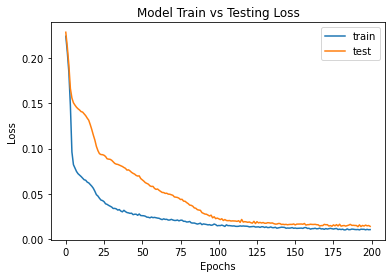

Normalized Test RMSE:  0.13485745742675617 0.09834701375573028 0.14663111013110935 0.08595315833924103
Test RMSE:  267.01776041117563 191.97338682744544 502.5047729872822 0.08595315833924103
Test R-squared:  0.8157370824587831 0.9148488978614325 0.862026630266645 0.945908088082095
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 50)             11400     
                                                                 
 dropout_15 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 20)             5680      
                                                                 
 dropout_16 (Dropout)        (None, 1, 20)             0         
                                                                 
 lstm_17 (LSTM)              (None, 

In [11]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 1 
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
# n_train_hours = 1936
n_train_hours = 1694
n_test = 484
train = values[:n_train_hours, :]
test = values[n_train_hours:n_train_hours+n_test, :]
out_test = values[n_train_hours+n_test:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
 
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# import xlsxwriter

# # Create file (workbook) and worksheet
# outWorkbook = xlsxwriter.Workbook("out.xlsx")
# outSheet = outWorkbook.add_worksheet()

# # Declare data
# values = [[rmse_1,norm_rmse_1,r_sq1],
#           [rmse_2,norm_rmse_2,r_sq2],
#           [rmse_3,norm_rmse_3,r_sq3],
#           [rmse_4,norm_rmse_4,r_sq4]]

# # Write headers
# outSheet.write("C1", "Tank_1")
# outSheet.write("D1", "Tank_2")
# outSheet.write("E1", "Tank_3")
# outSheet.write("F1", "Pump_1")

# # Write data to file
# outSheet.write("C2",values[0][0])
# outSheet.write("C3",values[0][1])
# outSheet.write("C4",values[0][2])

# outSheet.write("D2",values[1][0])
# outSheet.write("D3",values[1][1])
# outSheet.write("D4",values[1][2])

# outSheet.write("E2",values[2][0])
# outSheet.write("E3",values[2][1])
# outSheet.write("E4",values[2][2])

# outSheet.write("F2",values[3][0])
# outSheet.write("F3",values[3][1])
# outSheet.write("F4",values[3][2])

# outWorkbook.close()

In [12]:
out_test.shape

(241, 12)

### Box plot for rmse

           Tank_1      Tank_2      Tank_3     Pump_1
count   33.000000   33.000000   33.000000  33.000000
mean   144.161401  109.906095  134.719121   0.117114
std     29.680144   35.276328   34.676943   0.009327
min     88.629391   59.307521   74.722553   0.100214
25%    128.229447   79.751047  110.285824   0.109556
50%    142.568261  110.000502  126.947889   0.117160
75%    152.599295  128.335886  152.758458   0.124281
max    210.698327  197.403725  201.181122   0.132437


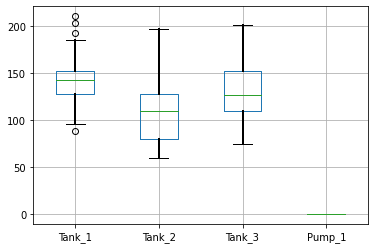

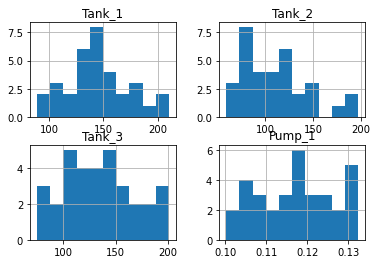

In [1]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box plot for normalised rmse

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.072809   0.056304   0.039311   0.117114
std     0.014990   0.018072   0.010119   0.009327
min     0.044762   0.030383   0.021804   0.100214
25%     0.064762   0.040856   0.032181   0.109556
50%     0.072004   0.056353   0.037043   0.117160
75%     0.077070   0.065746   0.044575   0.124281
max     0.106413   0.101129   0.058705   0.132437


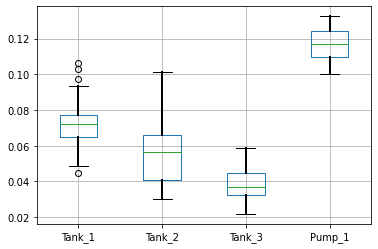

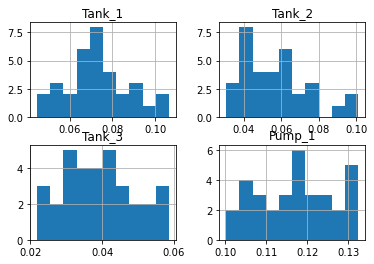

In [2]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('norm_rmse_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

### Box Plot for COefficient of Determination (R-Squared )

          Tank_1     Tank_2     Tank_3     Pump_1
count  33.000000  33.000000  33.000000  33.000000
mean    0.942453   0.970305   0.910426   0.937769
std     0.023750   0.019602   0.044893   0.009843
min     0.881927   0.912903   0.812304   0.920907
25%     0.938065   0.963188   0.891784   0.930348
50%     0.945940   0.972955   0.925264   0.938101
75%     0.956268   0.985784   0.943595   0.945875
max     0.979108   0.992138   0.974107   0.954713


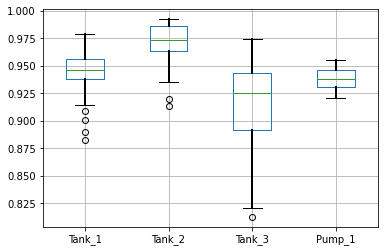

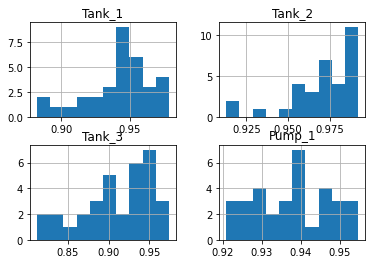

In [3]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
# load results file
results = read_csv('r_sq_multiple_results.csv', header=0)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot(whiskerprops = dict(linestyle='-', linewidth=2))
pyplot.show()
# histogram
results.hist()
pyplot.show()

In [5]:
import math
def rms(x,y):
    total = 0
    for i in range(len(x)):
        total += ((x[i]-y[i])**2)
    return math.sqrt(total/len(x))


p = [10,20,30,40]
q = [11,17,29,40]
print(rms(p,q))
val = [x for x in range(100,1000,100)]
val2 = [k + 2 for k in val]
# del val2[3]
print(rms(val,val2))

1.6583123951777
2.0


### Training, Vaidating and Testing

Epoch 1/100
27/27 - 14s - loss: 0.2035 - val_loss: 0.1404 - 14s/epoch - 527ms/step
Epoch 2/100
27/27 - 0s - loss: 0.1153 - val_loss: 0.1085 - 335ms/epoch - 12ms/step
Epoch 3/100
27/27 - 0s - loss: 0.0938 - val_loss: 0.0969 - 326ms/epoch - 12ms/step
Epoch 4/100
27/27 - 0s - loss: 0.0874 - val_loss: 0.0890 - 337ms/epoch - 12ms/step
Epoch 5/100
27/27 - 0s - loss: 0.0749 - val_loss: 0.0774 - 334ms/epoch - 12ms/step
Epoch 6/100
27/27 - 0s - loss: 0.0608 - val_loss: 0.0629 - 319ms/epoch - 12ms/step
Epoch 7/100
27/27 - 0s - loss: 0.0548 - val_loss: 0.0596 - 322ms/epoch - 12ms/step
Epoch 8/100
27/27 - 0s - loss: 0.0489 - val_loss: 0.0513 - 325ms/epoch - 12ms/step
Epoch 9/100
27/27 - 0s - loss: 0.0442 - val_loss: 0.0440 - 321ms/epoch - 12ms/step
Epoch 10/100
27/27 - 0s - loss: 0.0399 - val_loss: 0.0365 - 326ms/epoch - 12ms/step
Epoch 11/100
27/27 - 0s - loss: 0.0379 - val_loss: 0.0401 - 345ms/epoch - 13ms/step
Epoch 12/100
27/27 - 0s - loss: 0.0380 - val_loss: 0.0371 - 493ms/epoch - 18ms/step
E

Epoch 99/100
27/27 - 0s - loss: 0.0090 - val_loss: 0.0055 - 317ms/epoch - 12ms/step
Epoch 100/100
27/27 - 0s - loss: 0.0093 - val_loss: 0.0064 - 317ms/epoch - 12ms/step


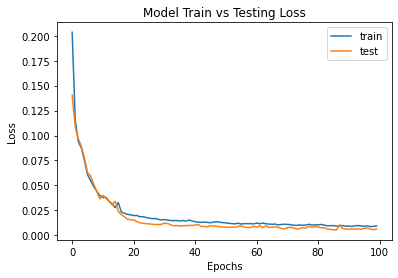

Normalized Test RMSE:  0.08077867749635566 0.055683410778701724 0.0318625657638576 0.12161985444797019
Test RMSE:  159.94176796767317 108.6940319342557 109.19301824922232 0.12161985444797019
Test R-squared:  0.931961958866624 0.9735938697043851 0.9447070442711404 0.9332989156204659
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             11400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 20)             5680      
                                                                 
 dropout_1 (Dropout)         (None, 5, 20)             0         
                                                                 
 lstm_2 (LSTM)               (None, 2

In [6]:
#from numpy import array

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#load dataset
dataset = read_csv('phy_cps.csv', header=0, index_col=0)
values = dataset.values
 
#integer encode wind direction, as it's the only categorical variable.
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
 
#ensure all data are float32 values
values = values.astype('float32')
 
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
 
#frame as supervised learning
n_hours = 5 
n_features = 6 
reframed = series_to_supervised(scaled, n_hours, 1)
values = reframed.values
n_train_hours = 1936
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
 

#Need to output four values, not one.
#design network
model = Sequential()
model.add(LSTM(50, activation='relu',return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam')
 
#fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.xlabel('Epochs')
pyplot.ylabel('Loss')
pyplot.title('Model Train vs Testing Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

#make a prediction
y_hat = model.predict(test_X)
 
#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
model.summary()

# Save the model to disk
model.save('multi_lstm_model.h5')
print('Model saved to disk')

### Load saved model

In [ ]:
from keras import read_csv
from keras.models import load_model

model = load_model('multi_lstm_model.h5')

#split into input and outputs
n_obs = n_hours * n_features
train_X = train[:, :n_obs]
train_y = train[:, -n_features:(-n_features+4)] #+2 because of indexing madness.
test_X = test[:, :n_obs]
test_y = test[:, -n_features:(-n_features+4)]
 
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

# Make a prediction
yhat = model.predict(out_test_X)

#calculate RMSE - CHANGED to output RMSE for each variable.
norm_rmse_1 = sqrt(mean_squared_error(y_hat[:,0], test_y[:,0])) #RMSE for the first variable (Tank_1)
norm_rmse_2 = sqrt(mean_squared_error(y_hat[:,1], test_y[:,1])) #RMSE for the second variable (Tank_2)
norm_rmse_3 = sqrt(mean_squared_error(y_hat[:,2], test_y[:,2])) #RMSE for the third variable (Tank_3)
norm_rmse_4 = sqrt(mean_squared_error(y_hat[:,3], test_y[:,3])) #RMSE for the fourth variable (Pump_1)
print('Normalized Test RMSE: ', norm_rmse_1, norm_rmse_2, norm_rmse_3, norm_rmse_4)
    
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions
 

#invert scaling for actual
test_y = test_y.reshape((len(test_y),4)) #changed 1 to 2
inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:4] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
 

    
#calculate RMSE - CHANGED to output RMSE for each variable.
rmse_1 = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0])) #RMSE for the first variable (Tank_1)
rmse_2 = sqrt(mean_squared_error(inv_y[:,1], inv_yhat[:,1])) #RMSE for the second variable (Tank_2)
rmse_3 = sqrt(mean_squared_error(inv_y[:,2], inv_yhat[:,2])) #RMSE for the third variable (Tank_3)
rmse_4 = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3])) #RMSE for the fourth variable (Pump_1)

r_sq1 = r2_score(inv_y[:,0], inv_yhat[:,0])
r_sq2 = r2_score(inv_y[:,1], inv_yhat[:,1])
r_sq3 = r2_score(inv_y[:,2], inv_yhat[:,2])
r_sq4 = r2_score(inv_y[:,3], inv_yhat[:,3])

print('Test RMSE: ', rmse_1, rmse_2, rmse_3, rmse_4)

print("Test R-squared: ", r_sq1, r_sq2, r_sq3, r_sq4)
